# Network construction

Network construction is aligned with the questions we aim to answer in the project. For this, the nodes represent the deputies. Two deputies are linked if their voting pattern is similar, which will be made clear below. 

We consider the votings that occurred during a period (year or legislature) in the plenary. 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

from DadosAbertosBrasil import camara

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import json
import time
from tqdm.notebook import trange
import requests
import re
import os

api = "https://dadosabertos.camara.leg.br/api/v2/"
dados = "http://dadosabertos.camara.leg.br/arquivos/"

## Votings 

### Downloading

Get votings per year and saving it. If you want to use the API, follow the code below. It takes more than 4 hours.  

If you want to download the files, follow the code below. It is faster, but it saves everything on the memory. 

In [2]:
for year in trange(1995,2022, desc='Year'): 
    filepath = '../dados/votacoes-{}.csv'.format(year)
    if os.path.exists(filepath): 
        continue
    else: 
        page = requests.get(dados+'votacoes/csv/votacoes-{}.csv'.format(year))
        with open(filepath, 'w') as f: 
            f.write(page.text)

Year:   0%|          | 0/27 [00:00<?, ?it/s]

In [11]:
for year in trange(1995,2022, desc='Year'): 
    filepath = '../dados/votacoesVotos-{}.csv'.format(year)
    if os.path.exists(filepath): 
        continue
    else: 
        page = requests.get(dados+'votacoesVotos/csv/votacoesVotos-{}.csv'.format(year))
        with open(filepath, 'w') as f: 
            f.write(page.text)

Year:   0%|          | 0/27 [00:00<?, ?it/s]

### Importing 

In [95]:
votings = pd.DataFrame()
for year in range(1995,2022): 
    votings = votings.append(pd.read_csv('../dados/votacoes-{}.csv'.format(year), 
                                         sep = ';', 
                                         index_col=0))

votings_plen = votings[votings.siglaOrgao=='PLEN'][['data']]

votings_plen['data'] = pd.to_datetime(votings_plen['data'])
votings_plen['year'] = votings_plen.data.apply(lambda x: x.year)
votings_plen['month'] = votings_plen.data.apply(lambda x: x.month)
votings_plen.drop(columns='data', inplace = True)

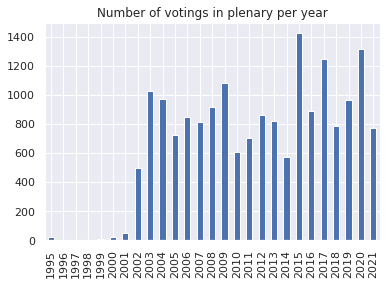

In [96]:
votings_plen.year.value_counts().sort_index().plot.bar()
plt.title('Number of votings in plenary per year')
plt.show()

In [97]:
votings[votings.data.str.contains('1996')].siglaOrgao.value_counts(normalize = True)

CCJC      0.514851
CFT       0.099010
CDC       0.075908
CSSF      0.072607
CTASP     0.056106
CE        0.039604
CVT       0.033003
CCTCI     0.033003
CDEICS    0.029703
CDU       0.013201
CFFC      0.009901
CAPADR    0.009901
CME       0.006601
PLEN      0.003300
MESA      0.003300
Name: siglaOrgao, dtype: float64

In [119]:
votes = pd.read_csv('../dados/votacoesVotos-2020.csv', sep = ';')

In [122]:
sampled = votings_plen[votings_plen.year==2020].sample().index[0]
votes[votes.idVotacao == sampled]

,idVotacao,uriVotacao,dataHoraVoto,voto,deputado_id,deputado_uri,deputado_nome,deputado_siglaPartido,deputado_uriPartido,deputado_siglaUf,deputado_idLegislatura,deputado_urlFoto
128984,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,PROS,https://dadosabertos.camara.leg.br/api/v2/part...,AP,56,http://www.camara.gov.br/internet/deputado/ban...
128985,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,204528,https://dadosabertos.camara.leg.br/api/v2/depu...,Adriana Ventura,NOVO,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,http://www.camara.gov.br/internet/deputado/ban...
128986,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,121948,https://dadosabertos.camara.leg.br/api/v2/depu...,Adriano do Baldy,PP,https://dadosabertos.camara.leg.br/api/v2/part...,GO,56,http://www.camara.gov.br/internet/deputado/ban...
128987,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,136811,https://dadosabertos.camara.leg.br/api/v2/depu...,Afonso Hamm,PP,https://dadosabertos.camara.leg.br/api/v2/part...,RS,56,http://www.camara.gov.br/internet/deputado/ban...
128988,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,204549,https://dadosabertos.camara.leg.br/api/v2/depu...,AJ Albuquerque,PP,https://dadosabertos.camara.leg.br/api/v2/part...,CE,56,http://www.camara.gov.br/internet/deputado/ban...
...,...,...,...,...,...,...,...,...,...,...,...,...
129242,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,178992,https://dadosabertos.camara.leg.br/api/v2/depu...,Vitor Lippi,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,http://www.camara.gov.br/internet/deputado/ban...
129243,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,178952,https://dadosabertos.camara.leg.br/api/v2/depu...,Walter Alves,MDB,https://dadosabertos.camara.leg.br/api/v2/part...,RN,56,http://www.camara.gov.br/internet/deputado/ban...
129244,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,160518,https://dadosabertos.camara.leg.br/api/v2/depu...,Weliton Prado,PROS,https://dadosabertos.camara.leg.br/api/v2/part...,MG,56,http://www.camara.gov.br/internet/deputado/ban...
129245,2260433-58,https://dadosabertos.camara.leg.br/api/v2/vota...,2020-12-07T17:09:43,Não,160632,https://dadosabertos.camara.leg.br/api/v2/depu...,Zé Silva,SOLIDARIEDADE,https://dadosabertos.camara.leg.br/api/v2/part...,MG,56,http://www.camara.gov.br/internet/deputado/ban...


In [100]:
camara.Votacao(cod=sampled).votos()

""


In [123]:
camara.Votacao(cod=sampled).dados

{'id': '2260433-58',
 'uri': 'https://dadosabertos.camara.leg.br/api/v2/votacoes/2260433-58',
 'data': '2020-12-07',
 'dataHoraRegistro': '2020-12-07T17:09:43',
 'siglaOrgao': 'PLEN',
 'uriOrgao': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/180',
 'idOrgao': 180,
 'uriEvento': 'https://dadosabertos.camara.leg.br/api/v2/eventos/60162',
 'idEvento': 60162,
 'descricao': 'Rejeitado o Requerimento. Sim: 3; não: 259; total: 262.',
 'aprovacao': 0,
 'descUltimaAberturaVotacao': None,
 'dataHoraUltimaAberturaVotacao': None,
 'ultimaApresentacaoProposicao': {'dataHoraRegistro': '2020-12-07T16:25:46',
  'descricao': 'Parecer proferido em Plenário pelo Relator, Dep. Gurgel (PSL-RJ), pela Comissão Especial, que conclui pela constitucionalidade, juridicidade e técnica legislativa; pela adequação financeira e orçamentária do PL nº 4.199, de 2020, e das Emendas apresentadas de nºs 1 a 112, e, no mérito, pela aprovação do PL nº 4.199, de 2020, e das emendas de nºs 21, 26, 27, 35, 40, 41, 42, 48

In [124]:
votings.loc[sampled]

uri                                              https://dadosabertos.camara.leg.br/api/v2/vota...
data                                                                                    2020-12-07
dataHoraRegistro                                                               2020-12-07T17:09:43
idOrgao                                                                                        180
uriOrgao                                         https://dadosabertos.camara.leg.br/api/v2/orga...
siglaOrgao                                                                                    PLEN
idEvento                                                                                     60162
uriEvento                                        https://dadosabertos.camara.leg.br/api/v2/even...
aprovacao                                                                                      0.0
votosSim                                                                                         3
votosNao  

In [136]:
votes = pd.read_csv('../dados/votacoesVotos-2020.csv', sep = ';')
#votings_plen[votes.idVotacao.unique()]

In [137]:
votes.voto.value_counts()

Não          79549
Sim          79090
Obstrução      551
Abstenção      271
Artigo 17      256
Name: voto, dtype: int64

In [141]:
camara.Votacao(cod='2191205-54').dados

{'id': '2191205-54',
 'uri': 'https://dadosabertos.camara.leg.br/api/v2/votacoes/2191205-54',
 'data': '2020-12-21',
 'dataHoraRegistro': '2020-12-21T20:26:58',
 'siglaOrgao': 'PLEN',
 'uriOrgao': 'https://dadosabertos.camara.leg.br/api/v2/orgaos/180',
 'idOrgao': 180,
 'uriEvento': 'https://dadosabertos.camara.leg.br/api/v2/eventos/60239',
 'idEvento': 60239,
 'descricao': 'Rejeitado o Requerimento. Sim: 21; não: 238; abstenção: 2; total; 261.',
 'aprovacao': 0,
 'descUltimaAberturaVotacao': None,
 'dataHoraUltimaAberturaVotacao': None,
 'ultimaApresentacaoProposicao': {'dataHoraRegistro': '2020-12-21T20:10:08',
  'descricao': 'Parecer proferido em Plenário pela Relatora ad hoc, Dep. Tereza Nelma (PSDB-AL), pela Comissão de Constituição e Justiça e de Cidadania, que conclui pela constitucionalidade, juridicidade e técnica legislativa da matéria, na forma do Substitutivo adotado pelo Relator da Comissão de Defesa dos Direitos das Pessoas com Deficiência.',
  'uriProposicaoCitada': 'htt

In [144]:
votes[votes.voto == 'Artigo 17'].deputado_nome.value_counts()

Rodrigo Maia            114
Marcos Pereira           29
Marcel van Hattem        23
João Roma                18
Soraya Santos            15
Luis Miranda             13
Paulo Ganime             11
Kim Kataguiri             8
Evair Vieira de Melo      7
Isnaldo Bulhões Jr.       4
Geovania de Sá            3
Marreca Filho             3
Marcelo Aro               2
Efraim Filho              2
Gil Cutrim                1
Orlando Silva             1
Juscelino Filho           1
Tabata Amaral             1
Name: deputado_nome, dtype: int64